In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from tempfile import TemporaryDirectory
from PIL import Image
import imageio
import imgaug as ia
from imgaug import augmenters as iaa
import random
import glob
import pandas as pd
import requests

cudnn.benchmark = True
plt.ion()
%matplotlib inline

#Setting up images

using augmetation on images found in the unsplash dataset and saving them in their respective folder

In [3]:
!wget https://unsplash.com/data/lite/latest

--2024-05-25 14:55:05--  https://unsplash.com/data/lite/latest
Resolving unsplash.com (unsplash.com)... 151.101.1.181, 151.101.193.181, 151.101.65.181, ...
Connecting to unsplash.com (unsplash.com)|151.101.1.181|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://unsplash-datasets.s3.amazonaws.com/lite/latest/unsplash-research-dataset-lite-latest.zip [following]
--2024-05-25 14:55:06--  https://unsplash-datasets.s3.amazonaws.com/lite/latest/unsplash-research-dataset-lite-latest.zip
Resolving unsplash-datasets.s3.amazonaws.com (unsplash-datasets.s3.amazonaws.com)... 52.216.152.28, 16.182.103.145, 3.5.28.166, ...
Connecting to unsplash-datasets.s3.amazonaws.com (unsplash-datasets.s3.amazonaws.com)|52.216.152.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494063166 (471M) [application/zip]
Saving to: ‘latest’

latest                0%[                    ] 109.49K   170KB/s               ^C


In [2]:
!unzip "/content/latest" -d "/content/drive/MyDrive/Culling/Unsplash_Dataset"

Archive:  /content/latest
  inflating: /content/drive/MyDrive/Culling/Unsplash_Dataset/collections.tsv000  
  inflating: /content/drive/MyDrive/Culling/Unsplash_Dataset/__MACOSX/._collections.tsv000  
  inflating: /content/drive/MyDrive/Culling/Unsplash_Dataset/colors.tsv000  
  inflating: /content/drive/MyDrive/Culling/Unsplash_Dataset/__MACOSX/._colors.tsv000  
  inflating: /content/drive/MyDrive/Culling/Unsplash_Dataset/conversions.tsv000  
  inflating: /content/drive/MyDrive/Culling/Unsplash_Dataset/__MACOSX/._conversions.tsv000  
  inflating: /content/drive/MyDrive/Culling/Unsplash_Dataset/DOCS.md  
  inflating: /content/drive/MyDrive/Culling/Unsplash_Dataset/keywords.tsv000  
  inflating: /content/drive/MyDrive/Culling/Unsplash_Dataset/__MACOSX/._keywords.tsv000  
  inflating: /content/drive/MyDrive/Culling/Unsplash_Dataset/photos.tsv000  
  inflating: /content/drive/MyDrive/Culling/Unsplash_Dataset/__MACOSX/._photos.tsv000  
  inflating: /content/drive/MyDrive/Culling/Unsplash_D

In [25]:
path = '/content/drive/MyDrive/Culling/Unsplash_Dataset/'
documents = ['photos', 'keywords', 'collections', 'conversions', 'colors']
unsplash_dataset = {}

for doc in documents:
  files = glob.glob(path + doc + ".tsv*")

  subsets = []
  for filename in files:
    df = pd.read_csv(filename, sep='\t', header=0)
    subsets.append(df)

  unsplash_dataset[doc] = pd.concat(subsets, axis=0, ignore_index=True)

In [26]:
unsplash_dataset["photos"]["photo_image_url"].head()

0    https://images.unsplash.com/uploads/1413387620...
1    https://images.unsplash.com/reserve/jEs6K0y1Sb...
2    https://images.unsplash.com/uploads/1412192004...
3    https://images.unsplash.com/reserve/ijl3tATFRp...
4    https://images.unsplash.com/reserve/6vaWXsQuSW...
Name: photo_image_url, dtype: object

In [ ]:
for i, url in enumerate(unsplash_dataset["photos"]["photo_image_url"]):
  try:
    image = Image.open(requests.get(url, stream=True).raw)
    image.save("/content/drive/MyDrive/Culling/Unsplash_Dataset/Unsplash_Images/unsplash" + str(i) + ".jpg")
  except:
    continue

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (121554000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [5]:
num_img = len(os.listdir("/content/drive/MyDrive/Culling/Unsplash_Dataset/Unsplash_Images"))
num_img

1756

In [6]:
data_dir = "/content/drive/MyDrive/Culling/Unsplash_Dataset/Unsplash_Images/"
filenames = [data_dir + f for f in os.listdir("/content/drive/MyDrive/Culling/Unsplash_Dataset/Unsplash_Images")]
for_training = random.sample(filenames, k=int(num_img*0.8)) #80-20 split
for_testing = [f for f in filenames if f not in for_training]
num_training, num_testing = len(for_training), len(for_testing)
num_training, num_testing

(1404, 352)

In [7]:
training_noisy = random.sample(for_training, k=int(num_training*0.25))
training_blurred = random.sample(for_training, k=int(num_training*0.25))
training_exposed = random.sample(for_training, k=int(num_training*0.25))
training_good = random.sample(for_training, k=int(num_training*0.25))

testing_noisy = random.sample(for_testing, k=int(num_testing*0.25))
testing_blurred = random.sample(for_testing, k=int(num_testing*0.25))
testing_exposed = random.sample(for_testing, k=int(num_testing*0.25))
testing_good = random.sample(for_testing, k=int(num_testing*0.25))

In [8]:
blur_sequence = iaa.Sequential([
    iaa.GaussianBlur(sigma=(14, 30)),
    iaa.Sometimes(0.6, iaa.MotionBlur(k=(3, 4), angle=[-180, 180])),
], random_order=True)

noise_sequence = iaa.Sequential([
    iaa.AddElementwise((-40, 40)),
    iaa.Sometimes(0.9, iaa.AdditiveGaussianNoise(scale=(10, 15))),
    iaa.Sometimes(0.1, iaa.AdditiveGaussianNoise(scale=(10, 50), per_channel=True))
], random_order=True)

exposure_sequence = iaa.Sometimes(0.5, then_list=iaa.Multiply((0.2, 0.5)), else_list=iaa.Multiply((1.6, 1.9)))

<ipython-input-9-d4932967b933>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  test = imageio.imread(training_blurred[10])


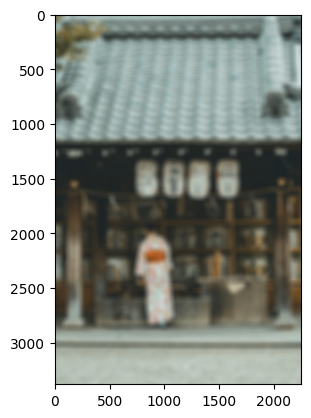

In [9]:
test = imageio.imread(training_blurred[10])
test = blur_sequence(image=test)
plt.imshow(test)

In [10]:
augmentors = {
    "blurry": blur_sequence,
    "noisy": noise_sequence,
    "exposed": exposure_sequence
}

save_dir = "/content/drive/MyDrive/Culling/dataset_v4/"

def save_images(image: str, aug: str = "good", im_type: str = "train", suffix: int = 0):
  x = save_dir + im_type + "/" + aug + "/"
  img = imageio.imread(image)
  if aug != "good":
    augmentor = augmentors[aug]
    img = augmentor(image=img)
  imageio.imwrite(x+aug+str(suffix)+"_v2.png", img)

saving and manipulating all images

In [11]:
len(training_noisy)

351

In [12]:
for i, f in enumerate(training_blurred):
  if i > 80:
    break
  save_images(f, "blurry", "train", i)
for i, f in enumerate(training_noisy):
  if i > 80:
    break
  save_images(f, "noisy", "train", i)
for i, f in enumerate(training_exposed):
  if i > 80:
    break
  save_images(f, "exposed", "train", i)
for i, f in enumerate(training_good):
  if i > 80:
    break
  save_images(f, "good", "train", i)

for i, f in enumerate(testing_blurred):
  if i > 80:
    break
  save_images(f, "blurry", "test", i)
for i, f in enumerate(testing_noisy):
  if i > 80:
    break
  save_images(f, "noisy", "test", i)
for i, f in enumerate(testing_exposed):
  if i > 80:
    break
  save_images(f, "exposed", "test", i)
for i, f in enumerate(testing_good):
  if i > 80:
    break
  save_images(f, "good", "test", i)

<ipython-input-10-a63fe7756a31>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image)


#Copying Learning!

training a model via transfer learning, following the tutorial on the pytorch website - https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = "/content/drive/MyDrive/Culling/dataset_v4"

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True)
              for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class_names, device

(['blurry', 'exposed', 'good', 'noisy'], device(type='cuda', index=0))

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best test Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [9]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 92.6MB/s]


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.3718 Acc: 0.3673
test Loss: 1.2036 Acc: 0.4568

Epoch 1/24
----------
train Loss: 1.3910 Acc: 0.4259
test Loss: 1.0670 Acc: 0.5463

Epoch 2/24
----------
train Loss: 1.2581 Acc: 0.4722
test Loss: 1.2013 Acc: 0.4414

Epoch 3/24
----------
train Loss: 1.1842 Acc: 0.5278
test Loss: 1.2738 Acc: 0.4938

Epoch 4/24
----------
train Loss: 1.3067 Acc: 0.5123
test Loss: 1.4811 Acc: 0.5185

Epoch 5/24
----------


In [ ]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['test'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        # ax = plt.subplot(2,2,1)
        # ax.axis('off')
        # ax.set_title(f'Predicted: {class_names[preds[0]]}')
        # plt.imshow(img.cpu().data[0])

        model.train(mode=was_training)
    return class_names[preds[0]]

In [ ]:
visualize_model_predictions(
    model_ft,
    img_path='/content/drive/MyDrive/Culling/dataset_v4/test/exposed/exposed1.png'
)

'exposed'

In [ ]:
torch.save(model_ft, "/content/drive/MyDrive/Culling/model_v3")

our dataset isnt very good, upon manual checking
i believe the model is pretty good

In [ ]:
for i in os.listdir('/content/drive/MyDrive/Culling/dataset_v4/test/good'):
  if (o:=visualize_model_predictions(model_ft, '/content/drive/MyDrive/Culling/dataset_v4/test/good/' + i)) != 'good':
    print(o, i)

exposed good9.png
exposed good12.png
exposed good13.png
exposed good27.png
exposed good37.png
noisy good39.png
noisy good50.png
noisy good54.png
exposed good55.png
exposed good58.png
exposed good64.png
exposed good65.png
blurry good74.png
exposed good90.png
noisy good128.png
exposed good131.png
exposed good132.png
exposed good133.png
exposed good135.png
exposed good136.png
exposed good137.png
noisy good142.png
exposed good147.png
exposed good153.png


In [ ]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

In [ ]:
torch.save(model_conv, "/content/drive/MyDrive/Culling/model_v4")

In [ ]:
culling_model = torch.load("/content/drive/MyDrive/Culling/modelv2")

In [ ]:
for i in os.listdir('/content/drive/MyDrive/Culling/dataset_v4/test/good'):
  if (o:=visualize_model_predictions(culling_model, '/content/drive/MyDrive/Culling/dataset_v4/test/good/' + i)) != 'good':
    print(o, i)

exposed good9.png
exposed good12.png
exposed good13.png
exposed good27.png
exposed good37.png
noisy good39.png
noisy good50.png
noisy good54.png
exposed good55.png
exposed good58.png
exposed good64.png
exposed good65.png
blurry good74.png
exposed good90.png
noisy good128.png
exposed good131.png
exposed good132.png
exposed good133.png
exposed good135.png
exposed good136.png
exposed good137.png
noisy good142.png
exposed good147.png
exposed good153.png
